In [1]:
import numpy as np
import cv2

img = cv2.imread("/mnt/c/Users/Work/Downloads/yolov5-master/yolov5-master/data/sample_vechile_det_dataset/train/images/17e5b483-7482-4977-919f-e9704a3f5cd0.jpg")
image_height, image_width = img.shape[:2]
labels = np.array([[0, 0.50716, 0.49336, 0.93099, 0.96132]])
segments = [
    np.array(
       [[    0.97266,     0.51617],
       [    0.94922,     0.46478],
       [    0.94748,     0.37182],
       [    0.91797,     0.33372],
       [      0.898,      0.2448],
       [    0.87804,     0.19861],
       [    0.81207,     0.13453],
       [    0.67925,     0.10797],
       [     0.7079,    0.012702],
       [    0.67708,    0.093534],
       [    0.65842,     0.11028],
       [    0.41971,     0.10624],
       [    0.32118,     0.11547],
       [     0.2296,     0.14319],
       [    0.19097,     0.17552],
       [    0.14236,     0.24018],
       [    0.11415,     0.29388],
       [   0.099826,     0.28176],
       [   0.062934,     0.28637],
       [   0.055556,     0.29677],
       [   0.057292,     0.33025],
       [   0.049045,     0.33718],
       [   0.041667,     0.37125],
       [   0.045139,     0.44169],
       [   0.072917,     0.55196],
       [    0.08724,     0.58083],
       [     0.1224,     0.58545],
       [    0.15321,     0.55601],
       [    0.42144,     0.73441],
       [    0.42708,     0.81236],
       [    0.45139,     0.88106],
       [    0.49306,      0.9463],
       [    0.54688,     0.97402],
       [    0.59679,     0.96016],
       [    0.62109,      0.9336],
       [    0.63715,      0.8955],
       [    0.69965,     0.90012],
       [     0.7322,      0.8903],
       [    0.78733,     0.85393],
       [    0.87413,     0.77021],
       [    0.93359,     0.68764],
       [    0.97092,      0.5485]]
    )
]

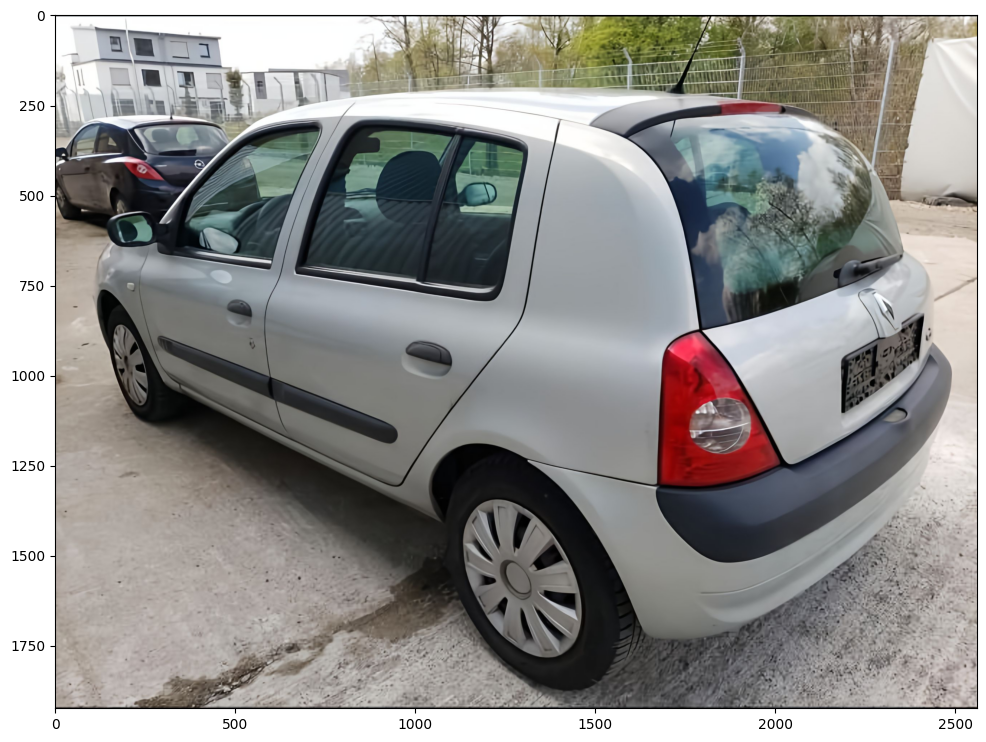

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
plt.imshow(img[:,:,::-1], cmap='gray')

In [3]:
from imantics import Polygons, Mask
import random
import copy


class PreAlbumentations:
    ## ONLY SUPPORT ONE OBJECT PER IMAGE FOR NOW
    
    # YOLOv5 Albumentations class (optional, only used if package is installed)
    def __init__(self, margin=0.1):
        self.transform = None
        # prefix = colorstr('pre load albumentations: ')
        try:
            import albumentations as A
            # check_version(A.__version__, '1.0.3', hard=True)  # version requirement
            
            # define margin for partial car
            self.margin = margin
            
            # define transforms for partial visible objects
            self.transforms_partial = A.Compose(
                [
                    A.RandomResizedCrop(height=350, width=350, scale=(0.8, 1.0), ratio=(0.9, 1.11), p=1.0),
                ], 
                bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
            )
            
            # define transforms for completely visible object
            self.transforms_commplete = A.Compose(
                [
                    A.RandomResizedCrop(height=350, width=350, scale=(0.8, 1.0), ratio=(0.9, 1.11), p=1.0),
                ], 
                bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
            )

            # LOGGER.info(prefix + ', '.join(f'{x}'.replace('always_apply=False, ', '') for x in T if x.p))
        except ImportError:  # package not installed, skip
            pass
        # except Exception as e:
            #LOGGER.info(f'{prefix}{e}')

    def __call__(self, im, labels, segments, probability_partial=0.3, probability_complete=0.5):
        if len(segments) > 1 or labels.shape[0] > 1:
            raise ValueError("multiple object per image are not supported yet")
        
        # get image height and width
        image_height, image_width = im.shape[:2]
        
        # check if image is partial or full
        # xi1, xi2, yi1, yi2 = self.margin, (1-self.margin), self.margin, (1-self.margin)
        # xb1, xb2, yb1, yb2 = xc-(w/2), w+xc-(w/2), yc-(h/2), h+yc-(h/2)
        
        # get bbox co-ordinates
        xc, yc, w, h = labels[0, 1:]
        
        partial_object = False
        if xc-w/2 < self.margin and \
            w+xc-w/2 > (1-self.margin) and \
            yc-h/2 < self.margin and \
            h+yc-h/2 > (1-self.margin):   
            partial_object = True
        
        # convert segments to mask
        segments_ = []
        for segment_ in segments:
            segment_[:, 0] *= image_width
            segment_[:, 1] *= image_height
            segments_.append(segment_)
        
        # apply augmentation for partial object
        if self.transforms_partial and random.random() < probability_partial and partial_object == True:
             # create mask
            mask = Polygons(segments_).mask(width=image_width, height=image_height)
            
            new = self.transforms_partial(image=im, bboxes=labels[:, 1:], class_labels=labels[:, 0], mask=mask.array)
            new_im, new_labels = new['image'], np.array([[c, *b] for c, b in zip(new['class_labels'], new['bboxes'])])
            new_segments = []
            for mask_ in new["mask"]:
                new_points = []
                for new_point in Mask(mask_).polygons().points:
                    new_point[:, 0] /= image_width
                    new_point[:, 1] /= image_height
                    new_points.append(new_point)
                    
                new_segments.append(new_points)
            return new_im, new_labels, new_segments
            
        # apply augmentation for complete object
        if self.transforms_commplete and random.random() < probability_complete and partial_object == False:
             # create mask
            mask = Polygons(segments_).mask(width=image_width, height=image_height)
            new = self.transforms_commplete(image=im, bboxes=labels[:, 1:], class_labels=labels[:, 0], mask=mask.array)
            new_im, new_labels = new['image'], np.array([[c, *b] for c, b in zip(new['class_labels'], new['bboxes'])])
            new_segments = []
            for mask_ in new["mask"]:
                new_points = []
                for new_point in Mask(mask_).polygons().points:
                    new_point[:, 0] /= image_width
                    new_point[:, 1] /= image_height
                    new_points.append(new_point)
                    
                new_segments.append(new_points)

            return new_im, new_labels, new_segments
        
        return im, labels, segments
        

In [4]:
a = PreAlbumentations(margin=0.1)

In [5]:
op = a(im=img, labels=labels, segments=segments, probability_partial=1.0, probability_complete=1.0)

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src data type = 0 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
im_, labels_, mask_ = op

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
plt.imshow(im_, cmap='gray')

In [ ]:
Mask(m.array).polygons().points